In [ ]:
!wget ''
!unzip 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tifffile as tiff
import imgaug as ia
from imgaug import augmenters as iaa

In [3]:
IMAGE_PATH = "/Users/nk_dan/Desktop/Project_geoclass/new_mt/collection"
MASK_PATH = "/Users/nk_dan/Desktop/Project_geoclass/new_mt/masks/buildings"

In [4]:
def get_rgb_data(img_id, path_to_img):
    image_path = path_to_img + '/' + str(img_id) + '.tif'
    image = tiff.imread(image_path)
    #image = image.transpose((1, 2, 0))
    #image = image.astype(np.float32)
    return image

In [25]:
image = get_rgb_data(24, IMAGE_PATH)
msk = get_rgb_data(24, MASK_PATH)
image.shape

(500, 500, 4)

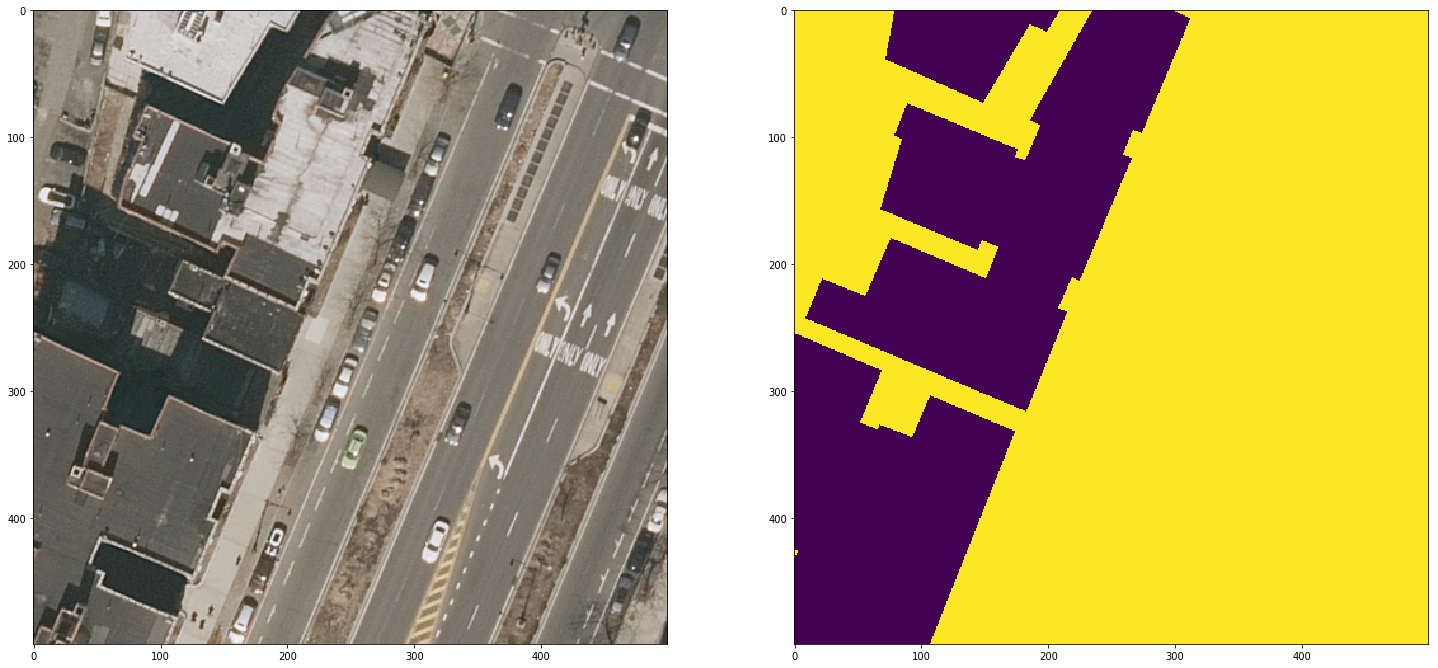

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(image)
axes[1].imshow(msk)

plt.show()

In [ ]:
#aug = ia.Sequential([
#      ia.Fliplr(0.5),
#      ia.Crop(percent=(0, 0),sample_independently=False),
#      ia.ContrastNormalization((0.75, 1.5)),
#      ia.Sometimes(0.25, ia.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02 * 255), per_channel=0.5)),
#      ia.Affine(rotate=(-90, 90), shear=(-5, 5), scale=(1, 1), mode='symmetric')
#    ], random_order=True)

In [10]:
class DataPrepare(object):

    def __init__(self, path_to_img, path_to_mask, batch_size, begin, end):
        self.mask_data = []
        self.data = []
        self.batch_size = batch_size
        for i in range(begin, end):
            img = get_rgb_data(i, path_to_img)
            mask = get_rgb_data(i, path_to_mask)
            self.data.append(img)
            self.mask_data.append(mask)
        self.data, self.mask_data = np.array(self.data), np.array(self.mask_data)
        self.i = 0
        self.begin = begin
        self.end = end
        self.leng = end - begin;

    def flow(self):
        while True:
            x_batch = []
            y_batch = []

            for i in range(self.batch_size):
                j = np.random.randint(0, self.leng)
                tmp_image = np.copy(self.data[j])
                tmp_mask = np.copy(self.mask_data[j])
                
                #tmp_image = np.copy(self.data[self.i])
                #tmp_mask = np.copy(self.mask_data[self.i])
            
                tmp_image = cv2.resize(tmp_image, (256, 256))
                tmp_mask = cv2.resize(tmp_mask, (256, 256))
            
                x_batch += [tmp_image]
                y_batch += [tmp_mask]
        
            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch)
        
            #self.i += 1
            #if self.i == self.leng:
            #    self.i = 0
      
            yield ((x_batch[:,:,:,:3], np.expand_dims(y_batch, -1)))

In [11]:
train_generator = DataPrepare(IMAGE_PATH, MASK_PATH, 16, 0, 500)
train_gen = train_generator.flow()
test_generator = DataPrepare(IMAGE_PATH, MASK_PATH, 16, 501, 699)
test_gen = test_generator.flow()
for x, y in train_generator.flow():
    break

In [12]:
x.shape

(16, 256, 256, 3)

In [13]:
y.shape

(16, 256, 256, 1)

SegNet

In [14]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

inp = Input(shape=(256, 256, 3))

convd1_1 = Conv2D(32, (3, 3), padding='same')(inp)
convd1_1 = Activation('relu')(convd1_1)

convd1_2 = Conv2D(32, (3, 3), padding='same')(convd1_1)
convd1_2 = Activation('relu')(convd1_2)

pool1 = MaxPooling2D(2)(convd1_2)


convd2_1 = Conv2D(64, (3, 3), padding='same')(pool1)
convd2_1 = Activation('relu')(convd2_1)

convd2_2 = Conv2D(64, (3, 3), padding='same')(convd2_1)
convd2_2 = Activation('relu')(convd2_2)

pool2 = MaxPooling2D(2)(convd2_2)


convd3_1 = Conv2D(128, (3, 3), padding='same')(pool2)
convd3_1 = Activation('relu')(convd3_1)

convd3_2 = Conv2D(128, (3, 3), padding='same')(convd3_1)
convd3_2 = Activation('relu')(convd3_2)

pool3 = MaxPooling2D(2)(convd3_2)


convd4_1 = Conv2D(256, (3, 3), padding='same')(pool3)
convd4_1 = Activation('relu')(convd4_1)

convd4_2 = Conv2D(256, (3, 3), padding='same')(convd4_1)
convd4_2 = Activation('relu')(convd4_2)

pool4 = MaxPooling2D(2)(conv_4_2)

up1 = UpSampling2D(2, interpolation='bilinear')(pool4)
convu1_1 = Conv2D(256, (3, 3), padding='same')(up1)
convu1_1 = Activation('relu')(convu1_1)

convu1_2 = Conv2D(256, (3, 3), padding='same')(convu1_1)
convu1_2 = Activation('relu')(convu1_2)


up2 = UpSampling2D(2, interpolation='bilinear')(convu1_2)
convu2_1 = Conv2D(128, (3, 3), padding='same')(up2)
convu2_1 = Activation('relu')(convu2_1)

convu2_2 = Conv2D(128, (3, 3), padding='same')(convu2_1)
convu2_2 = Activation('relu')(convu2_2)


up3 = UpSampling2D(2, interpolation='bilinear')(convu2_2)
convu3_1 = Conv2D(64, (3, 3), padding='same')(up3)
convu3_1 = Activation('relu')(convu3_1)

convu3_2 = Conv2D(64, (3, 3), padding='same')(convu3_1)
convu3_2 = Activation('relu')(convu3_2)



up4 = UpSampling2D(2, interpolation='bilinear')(convu3_2)
convu4_1 = Conv2D(32, (3, 3), padding='same')(up4)
convu4_1 = Activation('relu')(convu4_1)

convu4_2 = Conv2D(1, (3, 3), padding='same')(convu4_1)
result = Activation('sigmoid')(convu4_2)


model = Model(inputs=inp, outputs=result)

Using TensorFlow backend.


In [15]:
convu4_1

<tf.Tensor 'activation_15/Relu:0' shape=(?, 256, 256, 32) dtype=float32>

In [16]:
convd1_1

<tf.Tensor 'activation_1/Relu:0' shape=(?, 256, 256, 32) dtype=float32>

In [17]:
best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(adam, 'binary_crossentropy')

In [18]:
model.fit_generator(train_gen,
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=test_gen,
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
100/100 [==============================] - 10139s 101s/step - loss: 0.6479 - val_loss: 0.5975
Epoch 2/3
100/100 [==============================] - 2339s 23s/step - loss: 0.5389 - val_loss: 0.4895
Epoch 3/3
100/100 [==============================] - 2316s 23s/step - loss: 0.4664 - val_loss: 0.4603


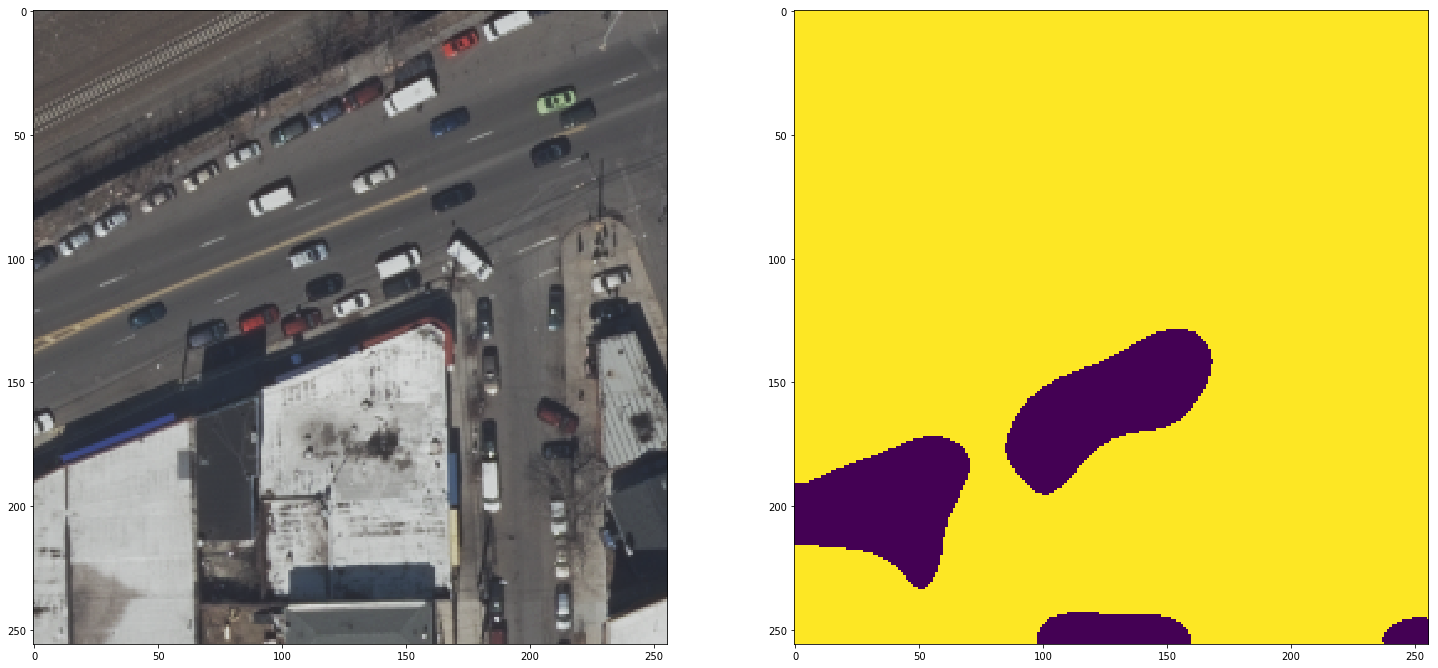

In [19]:
model.save('segnet2.model')
pred = model.predict(x)

im_id = 13
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5)

plt.show()

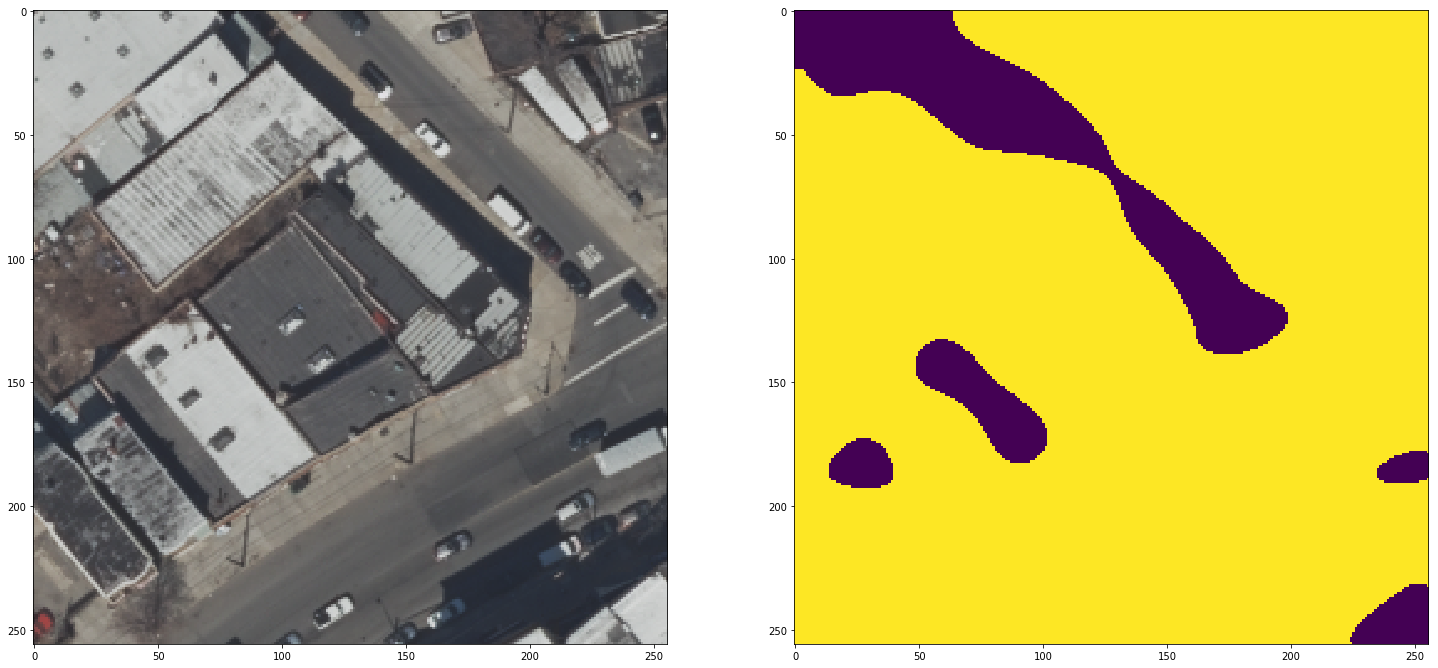

In [21]:
im_id = 9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5)

plt.show()

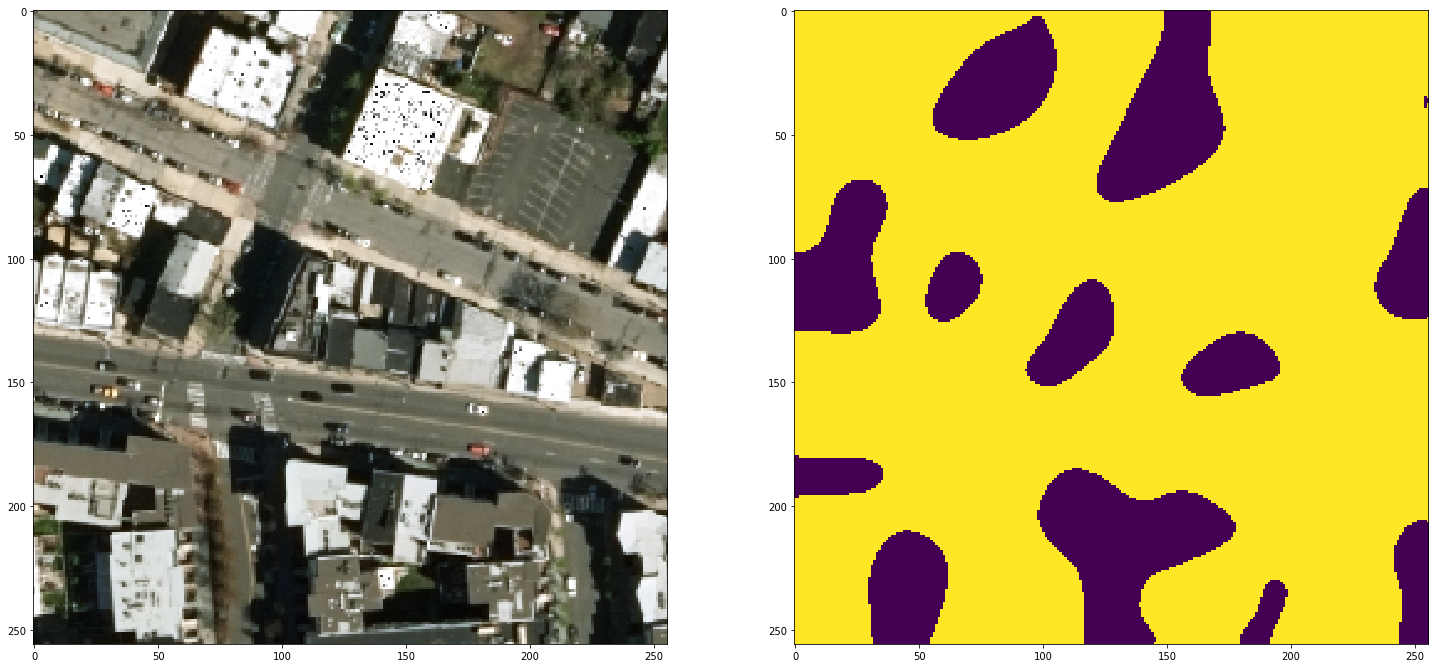

In [24]:
for a, b in test_generator.flow():
    break
    
pred = model.predict(a)
im_id = 9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(a[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5)

plt.show()